In [5]:
!pip install tslearn
import pandas as pd
from datetime import datetime
#import dateparser
import numpy as np
from tqdm.notebook import tqdm
import os
import json
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import matplotlib.pylab as pylab
import matplotlib.patches as patches
import pickle as pkl
from tslearn.clustering import TimeSeriesKMeans

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## custom_bin_counter(x,y,k)

topK intervals are calculated based on the values of first time interval

- x is the set of the first time interval
- y is the set of the second time interval
- k is the number of top workload ranges to consdier

The function returns in order:
 - the coverage of topK on the first time interval
 - the coverage of topK on the second time interval
 - dimension of the time intervals
 - total possible number of bins

I use Freedman-Diaconis approach based on [this](https://stats.stackexchange.com/questions/798/calculating-optimal-number-of-bins-in-a-histogram) links upvotes to choose the bin size.

In [6]:
def custom_bin_counter(x,y,k=10):
    q75, q25 = np.percentile(x, [75 ,25], axis=0)
    iqr = q75 - q25
    h = (2 * iqr) / ((x.shape[0])**(1/3))
    for i in range(len(h)):
        if h[i] == 0:
            h[i] = 1
    
    t = {}
    mins = x.min(axis=0)
    maxs = x.max(axis=0)
    
    ss = []
    total_bins = 1
    for i in range(len(h)):
        total_bins *= (maxs[i]-mins[i])/h[i]
        ss.append((maxs[i]-mins[i], h[i]))
    
    def get_bin_name(point):
        point = point - mins
        bin = [int(p/h[i]) for i,p in enumerate(point)]
        return bin
    
    for i in x:
        b = tuple(get_bin_name(i))
        if b not in t:
            t[b] = 0
        t[b] += 1

    k_keys_sorted = sorted(t, key=t.get, reverse=True)[:k]
    
    x_counter = 0
    for k in k_keys_sorted:
        x_counter += t[k]
    
    y_counter = 0
    for j in y:
        b = tuple(get_bin_name(j))
        if b in k_keys_sorted:
            y_counter += 1
    return (x_counter/x.shape[0], y_counter/y.shape[0],x.shape[1],total_bins)

In [7]:
def ClusterDistanceMax(timeSeries, groupIndices, centroid, m):
  if(len(groupIndices) < 1):
    return -1
  else:
    distances = []
    for g in groupIndices:
      index = timeSeries[g:g+m].to_numpy()
      distances.append(np.linalg.norm(centroid - index))
    return max(distances)

#Finds Centroid Distances
def GenCentroidDistance(centroids):
  distances = []
  for centroid in centroids:
    tempDistances = []
    for otherCentroid in centroids:
      tempDistances.append(np.linalg.norm(centroid - otherCentroid))
    distances.append(tempDistances)
  return distances

#Finds nearest neighbor in generated clusters shapelets
#Returns smallest distance between each point in provided timeseries and individual point within provided clusters. Also returns ratio of neighbors within a distance threshold
def NearestNeighborShapeletsClusters(timeSeries, clusters, clusterNum, clusterDistanceMax, m):
  coverage = []
  matches = 0
  for i in range(len(timeSeries)-m):
    point1 = timeSeries[i:i+m].to_numpy().T
    currDist = ["Empty", False, False]
    clusterCount = 0
    for point2 in clusters:
      point2 = point2.to_numpy().T
      tempDist = np.linalg.norm(point1 - point2)
      if currDist[0] == "Empty":
        currDist = [tempDist, clusterCount, clusterNum[i]]
      elif tempDist < currDist[0]:
        currDist = [tempDist, clusterCount, clusterNum[i]]
      clusterCount = clusterCount+1
    #distance threshold
    if currDist[0] <= clusterDistanceMax[currDist[2]]:
      matches = matches + 1
    coverage.append(currDist)
  return coverage, matches/(len(timeSeries)-m)

def custom_cluster_counter(x,y,k=10,m=1):
  x = pd.DataFrame(x)
  y = pd.DataFrame(y)
  numClusters = k

  model_mem = TimeSeriesKMeans(n_clusters=numClusters, metric="euclidean", n_init=5)
  model_mem.fit(x)
  labels_mem = pd.DataFrame(model_mem.labels_)
  centroids = model_mem.cluster_centers_
  centroidDistances = GenCentroidDistance(centroids)
  clusters = []
  for i in range(numClusters):
    tempCluster = []
    for l in range(len(labels_mem)):
      if labels_mem[0][l] == i:
        tempCluster.append(x[l:l+m])
    clusters.append(tempCluster)

  centroidSum = 0
  centroidCount = 0
  for i in range(len(clusters)-1):
    for l in range(i+1, len(clusters)):
      centroidSum = centroidSum + centroidDistances[i][l]
      centroidCount = centroidCount + 1
  centroidAvg = centroidSum/centroidCount
    
  innerDistances = []
  for i in range(numClusters):
    clusterIndices = []
    index = 0
    for n in labels_mem[0]:
      if i == n:
        clusterIndices.append(index)
      index = index+1
    innerDistances.append(ClusterDistanceMax(x, clusterIndices, centroids[i], m))


  clusterShapelets = []
  for c in clusters:
    temp = 0
    count = 0
    for win in c:
      if count == 0:
        temp = win.reset_index(drop=True)
      else:
        temp = temp+win.reset_index(drop=True)
      count = count+1
    if count == 0:
      fakeShapelet = []
      for i in range(m):
        fakeShapelet.append(-1)
      clusterShapelets.append(pd.DataFrame(fakeShapelet))
    else:
      temp = temp/count
      clusterShapelets.append(temp)
    
  nearestNeighbors, coverage = NearestNeighborShapeletsClusters(y, clusterShapelets, labels_mem[0].tolist(), innerDistances,m)
  
  return (1, coverage, x.shape[1], 10) #xcoverage, ycoverage, dimensions, number of bins

## Reading the data


If you don't want to download the dataset you can jump down a few cells and load intermediate files I generated.

You need to update the variable DATASET_PATH after you downloaded the dataset from [this link](https://github.com/Azure/AzurePublicDataset/blob/master/AzureFunctionsDataset2019.md).

Datasets are large, it takes time for them to load. Be patient :D

This is a sample of the dataset:

![alt text](dataset-sample.png "sample")

You can refer to the original [paper](https://www.usenix.org/conference/atc20/presentation/shahrad) to get more insight about the dataset.

Notice the comments on the next cells, when the dataset is being loaded.

In [8]:
DATASET_PATH = '/content/drive/MyDrive/Project/AzureDataset_FunctionCalls/'
from google.colab import drive
drive.mount('/content/drive')
days = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14']

Mounted at /content/drive


In [9]:
def run_filtering():
  days_dfs = {}
  days_apps = {}
  for d in tqdm(days):
      df = pd.read_csv(DATASET_PATH+'invocations_per_function_md.anon.d'+d+'.csv')
      
      # remove the functions that are triggered using the timer
      df = df[~df['Trigger'].isin(['timer'])]
      
      # only keep Apps which are called at least once a minute
      def filter_(df):
          temp = df.groupby('HashApp').sum().reset_index()
          temp['sum'] = temp[[str(i) for i in list(range(1,1441))]].sum(axis=1)
          temp = temp[temp['sum'] >= 1440]
          res = df[df['HashApp'].isin(temp['HashApp'].values)]
          return res
      
  #     df = filter_(df)
      
  #     days_apps[d] = set([appId for appId in df['HashApp'].unique() if df[df.HashApp == appId].shape[0] > 2])
      days_apps[d] = set([appId for appId in df['HashApp'].unique() if df[df.HashApp == appId].shape[0] > 0])
      days_dfs[d] = df
#run_filtering()

In [10]:
#Generate filtered datasets
def gen_datasets():
  for d in tqdm(days):
    with open(f'/content/drive/MyDrive/Project/AzureDataset_FunctionCalls/Stored_Analyzer_Data/days_apps{d}.txt', 'wb') as fp:
      pkl.dump(days_apps[d], fp)
    days_dfs[d].to_csv(path_or_buf=f'/content/drive/MyDrive/Project/AzureDataset_FunctionCalls/Stored_Analyzer_Data/days_dfs{d}.csv')
#gen_datasets()

In [11]:
#Retrieve filtered datasets
days_apps = {}
days_dfs = {}
for d in tqdm(days):
  with open(f'/content/drive/MyDrive/Project/AzureDataset_FunctionCalls/Stored_Analyzer_Data/days_apps{d}.txt', 'rb') as fp:
    days_apps[d] = pkl.load(fp)
  days_dfs[d] = pd.read_csv(f'/content/drive/MyDrive/Project/AzureDataset_FunctionCalls/Stored_Analyzer_Data/days_dfs{d}.csv')

  0%|          | 0/14 [00:00<?, ?it/s]

## zipf_law

I calculated the zipf law on the slope of the number of bins and the frequencies, this evaluates how skewed are the data points. 

Besides that, I calucated all the coverage values.

The answer is is they are heavily skewed.

Read more [here](https://en.wikipedia.org/wiki/Zipf%27s_law)

In [12]:
from scipy.stats import linregress
def zipf_law_slope_calculator(x,y):
    q75, q25 = np.percentile(x, [75 ,25], axis=0)
    iqr = q75 - q25
    h = (2 * iqr) / ((x.shape[0])**(1/3))
    for i in range(len(h)):
        if h[i] == 0:
            h[i] = 1

    mins = x.min(axis=0)
    maxs = x.max(axis=0)
    
    ss = []
    total_bins = 1
    for i in range(len(h)):
        total_bins *= (maxs[i]-mins[i])/h[i]
        ss.append((maxs[i]-mins[i], h[i]))
    
    def get_bin_name(point):
        point = point - mins
        bin = [int(p/h[i]) for i,p in enumerate(point)]
        #bin = [int(p/h[i]) for i,p in enumerate(point)]
        return bin
    #-------------------------------------------------------------
    t = {}
    for j in y:
        b = tuple(get_bin_name(j))
        if b not in t:
            t[b] = 0
        t[b] += 1
    
    k_keys_sorted = sorted(t, key=t.get, reverse=True)
    
    x_to_return = []
    y_to_return = []
    for i,k in enumerate(k_keys_sorted):
        x_to_return.append(i+1)
        y_to_return.append(t[k])

    
    x_log_to_return = np.log10(x_to_return)
    y_log_to_return = np.log10(y_to_return)
    line_test = linregress(x_log_to_return, y_log_to_return)
    return x_to_return, y_to_return, line_test.slope


days = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14']
data = {}
slopes = []
#for i in tqdm(range(0, len(days)-1)):
for i in tqdm(range(10, 11)):
    pair = {}
    trainss = {}
    testss = {}
    
    train_day = days[i]
    test_day = days[i+1]

    pair['train_day'] = train_day
    pair['test_day'] = test_day

    apps_intersections = days_apps[train_day].copy()
    pair['apps_intersections'] = apps_intersections

    df_train = days_dfs[train_day]
    df_test = days_dfs[test_day]
    
    apps_intersections = apps_intersections.intersection(days_apps[test_day])
    pair['number_of_apps'] = len(apps_intersections)
    pair['number_of_apps_same_functions'] = 0
    pair['function_counts'] = []
    pair['total_number_of_invocations'] = []
    pair['bins'] = []
    for app in tqdm(apps_intersections):
    
        sub_df_train = df_train[df_train.HashApp == app]
        sub_df_test = df_test[df_test.HashApp == app]
        #print(sub_df_train)
        import sys
        exit()

        train_functions = sorted(sub_df_train['HashFunction'].values)
        test_functions  = sorted(sub_df_test['HashFunction'].values)

        if train_functions != test_functions:
            continue
        pair['number_of_apps_same_functions'] += 1
        pair['function_counts'].append(len(train_functions))

        #print(sub_df_train.sort_values('HashFunction')[[str(i) for i in range(1,1441)]].values.transpose())

        train_data = sub_df_train.sort_values('HashFunction')[[str(i) for i in range(1,1441)]].values.transpose()
        test_data = sub_df_test.sort_values('HashFunction')[[str(i) for i in range(1,1441)]].values.transpose()
        pair['total_number_of_invocations'].append(train_data.sum() + test_data.sum())
        
        
        for k in range(1,11):
            if k not in testss:
                trainss[k] = []
                testss[k] = []
        train_coverage, test_coverage, dim, total_bins = custom_cluster_counter(train_data, test_data,k)
        #print(train_coverage, test_coverage, dim, total_bins)
        trainss[k].append(train_coverage)
        testss[k].append(test_coverage)

        x,y, slope_test = zipf_law_slope_calculator(train_data, test_data)
        slopes.append(slope_test)
        
        pair['bins'].append(total_bins)
        pair['trains'] = trainss
        pair['tests'] = testss
    data[i] = pair    

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9962 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/usr/local/lib/python3.7/dist-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/usr/local/lib/python3.7/dist-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/usr/local/lib/python3.7/dist-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/usr/local/lib/python3.7/dist-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/usr/local/lib/python3.7/dist-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: in

In [13]:
print(trainss)
print(testss)

{1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [14]:
with open(f'/content/drive/MyDrive/Project/AzureDataset_FunctionCalls/Stored_Analyzer_Data/testss{i}.txt', 'wb') as fp:
      pkl.dump(testss, fp)

In [15]:
with open(f'/content/drive/MyDrive/Project/AzureDataset_FunctionCalls/Stored_Analyzer_Data/days_apps{d}.txt', 'rb') as fp:
    testss[i] = pkl.load(fp)

## All applications or Popular applications
this depends on what applications' data is loaded in the previous cells.

For details of this you can refer to the thesis or the paper.

In [16]:
print('all applciations')
none_nans = []
count_nans = 0
for n in slopes:
    if np.isnan(n):
        count_nans += 1
    else:
        none_nans.append(n)
print(count_nans, len(slopes), np.mean(none_nans))

all applciations
25 8249 -4.293409625584886


In [17]:
print('popular applciations')
none_nans = []
count_nans = 0
for n in slopes:
    if np.isnan(n):
        count_nans += 1
    else:
        none_nans.append(n)
print(count_nans, len(slopes), np.mean(none_nans))

popular applciations
25 8249 -4.293409625584886


## Storing the results for further analysis

### These are the intermediate files I was talking about

I stored the data because inital analysis was time consuming. Further analysis can be easily done the pkl file without the need to run previous cells.

# Do not run this if you don't want to overwrite intermediate files (parsed-data)

In [18]:
#pkl.dump( data, open( '/content/drive/MyDrive/Project/parsed-data/no-timer-filtered-only-next-days-many-ks-more-than-0.pkl', "wb" ) )

## Final analysis and calulating the coverage

these details depend on what filtered are applied on the dataset when it was being loaded

no-timer-filtered-only-next-days-many-ks-more-than-0

 - only popular applications
 - no-timer-filtered: functions that are triggered using timers are not consdiered
 - only-next-days: only the coverage on the next day is calculated. Note that the coverage stays high on the next days too.
 - many-ks-more-than-0: any application that has more than 0 function is considered


In [19]:
with open('/content/drive/MyDrive/Project/parsed-data/no-timer-filtered-only-next-days-many-ks-more-than-0.pkl', "rb" ) as f:
    filtered_data = pkl.load(f)

data = filtered_data
number_of_apps = []
apps_intersections = []
function_counts = []
total_nubmer_of_invocations = []
pres_trains = {}
pres_tests = {}
number_of_apps_same_functions = []

for k in range(1,11):
    pres_trains[k] = []
    pres_tests[k] = []

for i in range(len(data)):
    number_of_apps.append(data[i]['number_of_apps'])
    apps_intersections.append(len(data[i]['apps_intersections']))
    function_counts.append(np.mean(data[i]['function_counts']))
    total_nubmer_of_invocations.append(np.mean(data[i]['total_number_of_invocations']))
    number_of_apps_same_functions.append(data[i]['number_of_apps_same_functions'])
    
    for k in range(1,11):
        pres_trains[k].append(np.array(data[i]['trains'][k]).mean())
        pres_tests[k].append(np.array(data[i]['tests'][k]).mean())

number_of_apps = np.array(number_of_apps)
apps_intersections = np.array(apps_intersections)
function_counts = np.array(function_counts)
total_nubmer_of_invocations = np.array(total_nubmer_of_invocations)
number_of_apps_same_functions = np.array(number_of_apps_same_functions)
print(10,np.percentile(np.array(data[0]['bins']), 10))
print(20,np.percentile(np.array(data[0]['bins']), 20))
print(50,np.percentile(np.array(data[0]['bins']), 50))
# print(np.percentile(np.array(data[0]['bins']), 99))
print('bins', np.percentile(np.array(data[0]['bins']), 100))
print('----')
print('number_of_apps', number_of_apps.min(), number_of_apps.mean(), number_of_apps.max())
print('number_of_apps_same_functions', number_of_apps_same_functions.min(), number_of_apps_same_functions.mean(), number_of_apps_same_functions.max())
print('apps_intersections',apps_intersections.min(), apps_intersections.mean(), apps_intersections.max())
print('function_counts', function_counts.min(), function_counts.mean(), function_counts.max())
print('total_nubmer_of_invocations', total_nubmer_of_invocations.min(), total_nubmer_of_invocations.mean(), total_nubmer_of_invocations.max())
for k in range(1,11):
    print(k, str(int(np.round(np.array(pres_trains[k]).mean(),2)*100))+'\%', str(int(np.round(np.array(pres_tests[k]).mean(), 2)*100))+'\%')
print(data[0]['bins'])


10 1.0
20 1.0
50 8.469324259929255
bins 1.1058513825607103e+104
----
number_of_apps 7336 9079.384615384615 10086
number_of_apps_same_functions 6165 7496.846153846154 8296
apps_intersections 8060 10536.153846153846 11561
function_counts 1.9007425367479922 2.007445374874323 2.0585525518244636
total_nubmer_of_invocations 157819.43929110107 203284.18444244206 257695.32421277897
1 80\% 80\%
2 88\% 87\%
3 91\% 90\%
4 92\% 91\%
5 93\% 92\%
6 94\% 93\%
7 95\% 94\%
8 95\% 94\%
9 96\% 95\%
10 96\% 95\%
[1.0, 15037059.374857461, 1500.0, 2.0, 1.0, 3.0, 51.0, 16.0, 88.99512158846298, 11.29243234657234, 1.0, 2809.0, 48.0, 1.0, 1052.0319834907846, 2.0, 5.0, 45.0, 98.0, 7.0, 2.0, 15.118537682105082, 1.0, 16.0, 84.0, 3.0, 22.58486469314468, 1.0, 22.58486469314468, 45.88670921781776, 18.0, 14.115540433215426, 5.64621617328617, 42.0, 34.713773509833494, 14.0, 48.0, 1.0, 2625106.716623187, 4.0, 54.0, 8.0, 144.0, 11156.923158413472, 2.0, 3.0, 42.0, 3.0, 5.64621617328617, 203.26378223830213, 13377.0, 15.0, 

no-timer-all-only-next-days-many-ks-more-than-0

 - all: all applications
 - no-timer-filtered: functions that are triggered using timers are not consdiered
 - only-next-days: only the coverage on the next day is calculated. Note that the coverage stays high on the next days too.
 - many-ks-more-than-0: any application that has more than 0 function is considered

In [20]:
with open('/content/drive/MyDrive/Project/parsed-data/no-timer-all-only-next-days-many-ks-more-than-0.pkl', "rb" ) as f:
    all_data = pkl.load(f)
data = all_data
number_of_apps = []
apps_intersections = []
function_counts = []
total_nubmer_of_invocations = []
pres_trains = {}
pres_tests = {}
number_of_apps_same_functions = []


for k in range(1,11):
    pres_trains[k] = []
    pres_tests[k] = []

for i in range(len(data)):
    number_of_apps.append(data[i]['number_of_apps'])
    apps_intersections.append(len(data[i]['apps_intersections']))
    function_counts.append(np.mean(data[i]['function_counts']))
    total_nubmer_of_invocations.append(np.mean(data[i]['total_number_of_invocations']))
    number_of_apps_same_functions.append(data[i]['number_of_apps_same_functions'])

    
    for k in range(1,11):
        pres_trains[k].append(np.array(data[i]['trains'][k]).mean())
        pres_tests[k].append(np.array(data[i]['tests'][k]).mean())

number_of_apps = np.array(number_of_apps)
apps_intersections = np.array(apps_intersections)
function_counts = np.array(function_counts)
total_nubmer_of_invocations = np.array(total_nubmer_of_invocations)
number_of_apps_same_functions = np.array(number_of_apps_same_functions)

print(np.percentile(np.array(data[0]['bins']), 10))
print(np.percentile(np.array(data[0]['bins']), 20))
print(50,np.percentile(np.array(data[0]['bins']), 50))
print(np.percentile(np.array(data[0]['bins']), 99))
print('bins', np.percentile(np.array(data[0]['bins']), 100))
print('----')

print('number_of_apps', number_of_apps.min(), number_of_apps.mean(), number_of_apps.max())
print('number_of_apps_same_functions', number_of_apps_same_functions.min(), number_of_apps_same_functions.mean(), number_of_apps_same_functions.max())

print('apps_intersections',apps_intersections.min(), apps_intersections.mean(), apps_intersections.max())
print('function_counts', function_counts.min(), function_counts.mean(), function_counts.max())
print('total_nubmer_of_invocations', total_nubmer_of_invocations.min(), total_nubmer_of_invocations.mean(), total_nubmer_of_invocations.max())
for k in range(1,11):
    print(k, str(int(np.round(np.array(pres_trains[k]).mean(),2)*100))+'\%', str(int(np.round(np.array(pres_tests[k]).mean(), 2)*100))+'\%')

1.0
1.0
50 8.469324259929255
11637977933687.488
bins 1.1058513825607103e+104
----
number_of_apps 7336 9079.384615384615 10086
number_of_apps_same_functions 6165 7496.846153846154 8296
apps_intersections 8060 10536.153846153846 11561
function_counts 1.9007425367479922 2.007445374874323 2.0585525518244636
total_nubmer_of_invocations 157819.43929110107 203284.18444244206 257695.32421277897
1 80\% 80\%
2 88\% 87\%
3 91\% 90\%
4 92\% 91\%
5 93\% 92\%
6 94\% 93\%
7 95\% 94\%
8 95\% 94\%
9 96\% 95\%
10 96\% 95\%


## Additional analysis: CDF of invocation counts
the file `parsed-data/invocations_per_day.txt` contains invocation per day for each application, sorted. I can't find the script that generated that file. You can try to re-do that. You need to concat all datafames and performe some aggregation operations.

This analysis is a redo of what was originaly done on the original paper, it looks somehow similar but not 100%. Not sure why.

In [21]:
with open('/content/drive/MyDrive/Project/parsed-data/invocations_per_day.txt') as f:
    sums = [float(f) for f in f.read().split('\n')[:-1]]

In [22]:
once_per_minute_idx = -1
subset_sum = 0
for i,s in enumerate(sums):
    if s > 1440:
        once_per_minute_idx = i
        break
for s in sums:
    if s > 1440:
        subset_sum += s
once_per_minute_idx

once_per_hour_idx = -1
subset_sum = 0
for i,s in enumerate(sums):
    if s > 24:
        once_per_hour_idx = i
        break
for s in sums:
    if s > 24:
        subset_sum += s
once_per_hour_idx

once_per_day_idx = -1
subset_sum = 0
for i,s in enumerate(sums):
    if s > 1:
        once_per_day_idx = i
        break
for s in sums:
    if s > 1:
        subset_sum += s
once_per_day_idx

4458

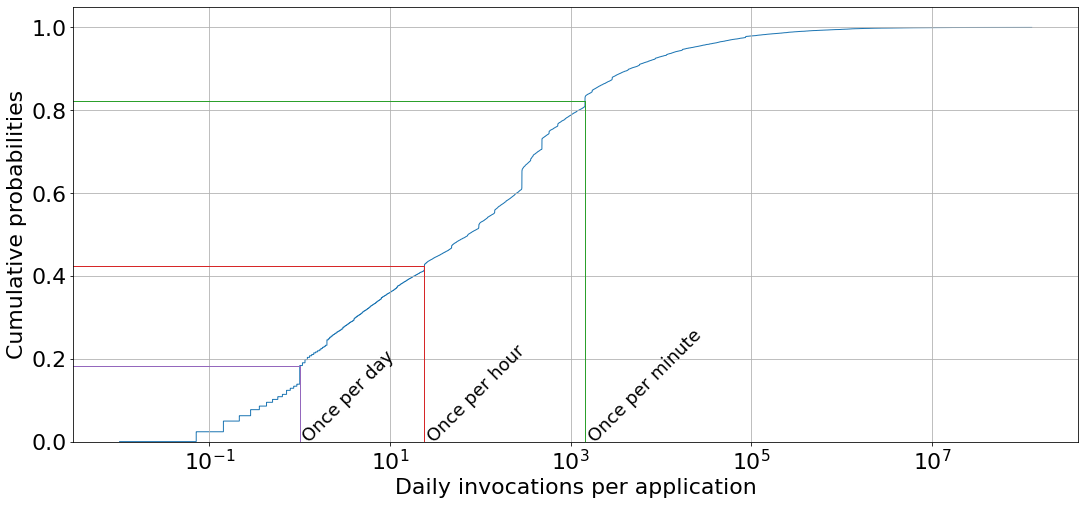

In [23]:
import matplotlib
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
n_bins = 100000
fig, ax = plt.subplots(1,1,figsize=(18, 8))
bins = np.logspace(np.log10(0.01),np.log10(max(sums)), n_bins)
n, bins, patches = ax.hist(sums, bins=bins, density=True, histtype='step', cumulative=True)

poly = ax.findobj(plt.Polygon)[0]
vertices = poly.get_path().vertices

# Keep everything above y == 0. You can define this mask however
# you need, if you want to be more careful in your selection.
keep = vertices[:, 1] > -1
keep[-1] = False

# Construct new polygon from these "good" vertices
new_poly = plt.Polygon(vertices[keep], closed=False, fill=False,
                       edgecolor=poly.get_edgecolor(),
                       linewidth=poly.get_linewidth())
poly.set_visible(False)
ax.add_artist(new_poly)
plt.draw()



linew = 1
ax.add_line(matplotlib.lines.Line2D([1440,1440],[0,(once_per_minute_idx)/len(sums)], linewidth=linew,c='tab:green'))
ax.add_line(matplotlib.lines.Line2D([0,1440],[(once_per_minute_idx)/len(sums),(once_per_minute_idx)/len(sums)], linewidth=linew,c='tab:green'))

ax.add_line(matplotlib.lines.Line2D([24,24],[0,(once_per_hour_idx)/len(sums)], linewidth=linew,c='tab:red'))
ax.add_line(matplotlib.lines.Line2D([0,24],[(once_per_hour_idx)/len(sums),(once_per_hour_idx)/len(sums)], linewidth=linew, c='tab:red'))

ax.add_line(matplotlib.lines.Line2D([1,1],[0,(once_per_day_idx)/len(sums)], linewidth=linew,c='tab:purple'))
ax.add_line(matplotlib.lines.Line2D([0,1],[(once_per_day_idx)/len(sums),(once_per_day_idx)/len(sums)], linewidth=linew,c='tab:purple'))


# ax.add_patch(
#     plt.Rectangle(
#         xy=(1440, 0),
#         width=max(sums)-1440,
#         height=(once_per_minute_idx)/len(sums),
#         zorder=-1,
#         linewidth=0,
#         alpha=0.5,
#         color=colors[0],
#         fill=True
#     )
# )

# ax.add_patch(
#     plt.Rectangle(
#         xy=(0, (once_per_minute_idx)/len(sums)),
#         width=max(sums),
#         height=1-(once_per_minute_idx)/len(sums),
#         zorder=-1,
#         linewidth=0,
#         alpha=0.5,
#         color=colors[0],
#         fill=True
#     )
# )
# ax.text(10e-3 * 0.4, 0.9, '18%', fontsize=18)
ax.text(1, 0.00, 'Once per day', fontsize=18, rotation=45)
ax.text(24, 0.00, 'Once per hour', fontsize=18, rotation=45)
ax.text(1441, 0.00, 'Once per minute', fontsize=18, rotation=45)
ax.grid(True)
# ax.set_yticklabels([str(int(y * 100)) + '%' for y in ax.get_yticks()])
ax.set_xscale('log')
ax.set_xlabel('Daily invocations per application',fontsize=BIGGER_SIZE)
ax.set_ylabel('Cumulative probabilities',fontsize=BIGGER_SIZE)
# plt.savefig('figures/cdf-daily-invocatinos-per-app.png')
plt.show()